In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator
from matplotlib.gridspec import GridSpec

import astropy.constants as const
import tables
from sn_companion_collision.sn_collision import kasen, get_filter_trans

from scipy.signal import savgol_filter

In [2]:
%matplotlib notebook

In [3]:
# meta data
z = 0.0094
tb_max = 58863.34
t_fl = -17.4928

In [4]:
abs_mag_df = pd.read_csv('abs_mag_p48.csv')
abs_mag_df.head(5)

,t_restframe,abs_mag,mag_unc,filt
0,0.779844,-16.121753,0.015658,r
1,0.847793,-15.760670,0.014474,i
2,0.867332,-16.364536,0.010132,g
3,3.731084,-16.083966,0.017258,r
4,3.789436,-15.874392,0.015882,g


### Synthesize the light curves

In [5]:
g_ztf = get_filter_trans.get_g_ztf_tc()
r_ztf = get_filter_trans.get_r_ztf_tc()
i_ztf = get_filter_trans.get_i_ztf_tc()

uvm2 = get_filter_trans.get_uvm2_tc()
uvw1 = get_filter_trans.get_uvw1_tc()
uvw2 = get_filter_trans.get_uvw2_tc()

/Users/adamamiller/software/aam_python/sn_companion_collision/sn_collision/kasen.py:93: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  self.wavelength.max())[0]
/Users/adamamiller/software/aam_python/sn_companion_collision/sn_collision/kasen.py:101: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting

In [6]:
h5file = tables.open_file('../data/models/polin2019/Mtot_0.96/0.92_0.04_doubledet.h5', mode="r")
Lnu = np.zeros((500, 5206))
for r_num, r in enumerate(h5file.root.Lnu):
    Lnu[r_num] = r

nu = np.zeros(5206)
for r_num, r in enumerate(h5file.root.nu):
    nu[r_num] = r
wave = const.c.to('Angstrom/s').value/nu
Llambda = nu**2/const.c.to('Angstrom/s').value*Lnu

In [7]:
t_DD_0_92_0_04 = np.array(h5file.root.time)/86400
g_DD_0_92_0_04 = np.zeros_like(t_DD_0_92_0_04)
r_DD_0_92_0_04 = np.zeros_like(t_DD_0_92_0_04)
i_DD_0_92_0_04 = np.zeros_like(t_DD_0_92_0_04)
m2_DD_0_92_0_04 = np.zeros_like(t_DD_0_92_0_04)
w1_DD_0_92_0_04 = np.zeros_like(t_DD_0_92_0_04)

for t_step, time in enumerate(t_DD_0_92_0_04):
    dd_spec = kasen.Spectrum(wave, Llambda[t_step]/(4*np.pi*(10*const.pc.to('cm').value)**2))
    syn_phot = np.zeros(6)
    for filt_num, filt in enumerate([g_ztf, r_ztf, i_ztf, uvm2, uvw1]):
        f_lambda = dd_spec.SyntheticPhotometry(filt)
        f_nu = f_lambda * filt.wavelength_eff**2/const.c.to('Angstrom/s').value * 1e23
        syn_phot[filt_num] = -2.5*np.log10(f_nu/3631)
    
    g_DD_0_92_0_04[t_step] = syn_phot[0]
    r_DD_0_92_0_04[t_step] = syn_phot[1]
    i_DD_0_92_0_04[t_step] = syn_phot[2]
    m2_DD_0_92_0_04[t_step] = syn_phot[3]
    w1_DD_0_92_0_04[t_step] = syn_phot[4]

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/adamamiller/software/aam_python/sn_companion_collision/sn_collision/kasen.py:131: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(func, self.wavelength.min(), self.wavelength.max())[0]
/Users/adamamiller/software/aam_python/sn_companion_collision/sn_collision/kasen.py:131: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(func, self.wavelength.min(), self

In [8]:
# figure out time offset
t_grid = np.linspace(0,5,126)
r_early = np.where((abs_mag_df.filt == 'r') & 
                   (abs_mag_df.t_restframe <= 30))
g_early = np.where((abs_mag_df.filt == 'g') & 
                   (abs_mag_df.t_restframe <= 30))
i_early = np.where((abs_mag_df.filt == 'i') & 
                   (abs_mag_df.t_restframe <= 30))

chi2_grid = np.zeros_like(t_grid)
for tnum, toff in enumerate(t_grid):
    model = np.interp(abs_mag_df.t_restframe.iloc[r_early], t_DD_0_92_0_04 - toff, r_DD_0_92_0_04)
    chi2_grid[tnum] += np.sum((abs_mag_df.abs_mag.iloc[r_early].values - model)**2/abs_mag_df.mag_unc.iloc[r_early].values**2)

#     model = np.interp(abs_mag_df.t_restframe.iloc[g_early], t_DD_0_92_0_04 - toff, g_DD_0_92_0_04)
#     chi2_grid[tnum] += np.sum((abs_mag_df.abs_mag.iloc[g_early].values - model)**2/abs_mag_df.mag_unc.iloc[g_early].values**2)

    model = np.interp(abs_mag_df.t_restframe.iloc[i_early], t_DD_0_92_0_04 - toff, i_DD_0_92_0_04)
    chi2_grid[tnum] += np.sum((abs_mag_df.abs_mag.iloc[i_early].values - model)**2/abs_mag_df.mag_unc.iloc[i_early].values**2)
    
print(t_grid[np.argmin(chi2_grid)])

0.72


<IPython.core.display.Javascript object>


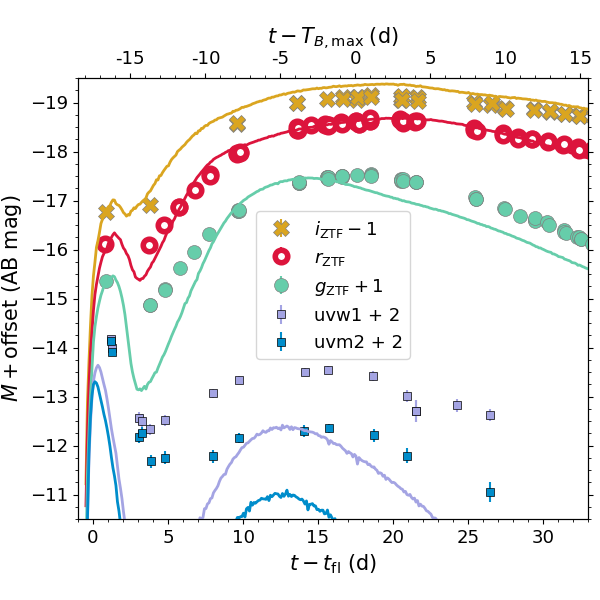

In [9]:
color_dict = {1: 'MediumAquaMarine',
              2: 'Crimson', 
              3: 'Goldenrod', 
              "uvw2": "#D71DE5",
              "uvm2": "#008DCB",
              "uvw1": "#A4A4E3"}

mark_color_dict = {2: 'white',
                   1: 'MediumAquaMarine',
                   3: 'Goldenrod'}
sym_dict = {1: 'o',
            2: 'o',
            3: 'X'}
mec_dict = {2: 'Crimson',
            1: '0.5',
            3: '0.5'}
mew_dict = {2: 4,
            1: 0.5,
            3: 0.5}
ms_dict = {2: 9,
           1: 10,
           3: 12}
filt_dict = {1:'g', 
             2:'r', 
             3:'i'}
label_dict = {1:r'$g_\mathrm{ZTF} + 1$', 
             2:r'$r_\mathrm{ZTF}$', 
             3:r'$i_\mathrm{ZTF} - 1$'}
zorder_dict = {3: 10,
               1: 5,
               2: 2}
offset_dict = {3: -1,
               1: 1,
               2: 0,
               "uvw2": 4,
               "uvm2": 2,
               "uvw1": 2}

t_offset = 0.72

fig, ax = plt.subplots(figsize=(6,6))

for filt, model_flux in zip([3,2,1], 
                            [i_DD_0_92_0_04,
                             r_DD_0_92_0_04,
                             g_DD_0_92_0_04]):
    this_filt = np.where(abs_mag_df.filt == filt_dict[filt])
    
    ax.errorbar(abs_mag_df.t_restframe.values[this_filt], 
                abs_mag_df.abs_mag.values[this_filt] + offset_dict[filt], 
                abs_mag_df.mag_unc.values[this_filt], 
                fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                mec=mec_dict[filt], mew=mew_dict[filt],
                label = label_dict[filt], zorder = zorder_dict[filt], 
                ms=ms_dict[filt])
    
    ax.plot(t_DD_0_92_0_04-t_offset, 
            model_flux + offset_dict[filt], 
            color=color_dict[filt], 
            lw=2, zorder=100)



uvw1_obs = np.where(abs_mag_df.filt == 'UVW1')
ax.errorbar(abs_mag_df.t_restframe.values[uvw1_obs], 
            abs_mag_df.abs_mag.values[uvw1_obs]  + offset_dict['uvw1'], 
            abs_mag_df.mag_unc.values[uvw1_obs],
            fmt = 's', color=color_dict['uvw1'], ecolor=color_dict['uvw1'],
            mec='k', mew=0.5,
            label='uvw1 + 2')
ax.plot(t_DD_0_92_0_04-t_offset, 
        w1_DD_0_92_0_04  + offset_dict['uvw1'], 
        color=color_dict['uvw1'], 
        lw=2, zorder=100)

uvm2_obs = np.where(abs_mag_df.filt == 'UVM2')
ax.errorbar(abs_mag_df.t_restframe.values[uvm2_obs], 
            abs_mag_df.abs_mag.values[uvm2_obs]  + offset_dict['uvm2'], 
            abs_mag_df.mag_unc.values[uvm2_obs],
            fmt = 's', color=color_dict['uvm2'], ecolor=color_dict['uvm2'],
            mec='k', mew=0.5,
            label='uvm2 + 2')
ax.plot(t_DD_0_92_0_04-t_offset, 
        m2_DD_0_92_0_04  + offset_dict['uvm2'], 
        color=color_dict['uvm2'], 
        lw=2, zorder=100)

ax.set_ylim(-10.5, -19.5)
ax.set_ylabel(r'$M + \mathrm{offset}$ (AB mag)', fontsize=15)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_xlim(-1, 33)
ax.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=15)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='both', right=True, labelsize=13)

ax.legend(loc=10, fontsize=13,bbox_to_anchor=(0.5,0.53,0,0))

ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 15)
ax2.set_xlim(ax.get_xlim())

bmax_ticks = np.arange(-15,20,5)
ax2.set_xticks(np.array(bmax_ticks) - t_fl)
ax2.set_xticklabels(bmax_ticks, fontsize = 12)
ax2.xaxis.set_minor_locator(FixedLocator(np.linspace(-20, 20, 41) - t_fl))
ax2.tick_params(labelsize=13)


fig.subplots_adjust(top=0.87,right=0.98,bottom=0.135, left=0.13)
# fig.savefig('../paper/figures/double_det.pdf')

## Plot spectra and light curve

In [10]:
def plot_box_spec(wave, flux): 
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave)/2
    wv_plot = np.append(wave[0]-(wave[1]-wave[0])/2, 
                        np.append(np.repeat(wv_plot[0:-1], 2), 
                                  wave[-1]+(wave[-1]-wave[-2])/2))
    
    return wv_plot, flux_plot

<IPython.core.display.Javascript object>


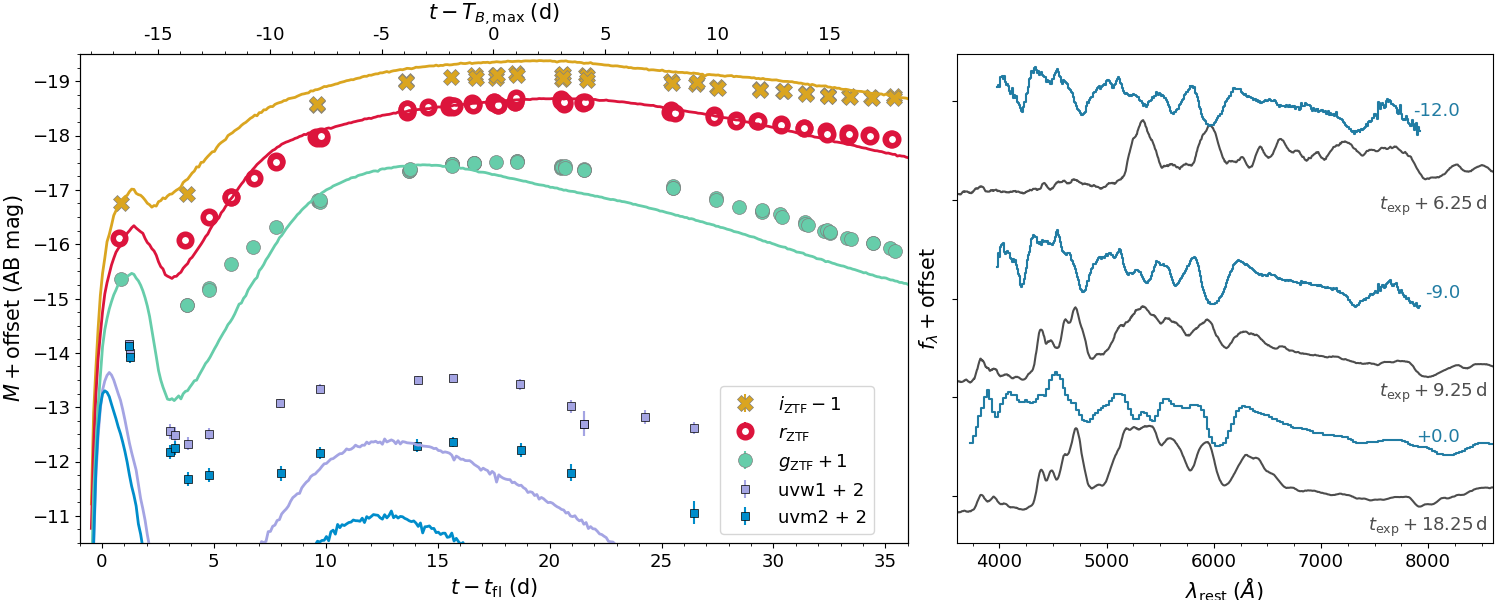

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


In [11]:
aam_colors = {'mustard': "#E29930",
             'blue': "#217CA3",
             'asphalt': "#32384D",
             'navy': "#444C5C",
             'punch': "#CE5A57",
             'ocean': "#78A5A3",
             'warm': "#E1B16A",}

fig = plt.figure(figsize=(15,6), constrained_layout=True)

gs = GridSpec(1, 5, figure=fig)
ax = fig.add_subplot(gs[:, 0:3])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax_spec = fig.add_subplot(gs[:, 3:])

for filt, model_flux in zip([3,2,1], 
                            [i_DD_0_92_0_04,
                             r_DD_0_92_0_04,
                             g_DD_0_92_0_04]):
    this_filt = np.where(abs_mag_df.filt == filt_dict[filt])
    
    ax.errorbar(abs_mag_df.t_restframe.values[this_filt], 
                abs_mag_df.abs_mag.values[this_filt] + offset_dict[filt], 
                abs_mag_df.mag_unc.values[this_filt], 
                fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                mec=mec_dict[filt], mew=mew_dict[filt],
                label = label_dict[filt], zorder = zorder_dict[filt], 
                ms=ms_dict[filt])
    
    ax.plot(t_DD_0_92_0_04-t_offset, 
            model_flux + offset_dict[filt], 
            color=color_dict[filt], 
            lw=2, zorder=100)



uvw1_obs = np.where(abs_mag_df.filt == 'UVW1')
ax.errorbar(abs_mag_df.t_restframe.values[uvw1_obs], 
            abs_mag_df.abs_mag.values[uvw1_obs]  + offset_dict['uvw1'], 
            abs_mag_df.mag_unc.values[uvw1_obs],
            fmt = 's', color=color_dict['uvw1'], ecolor=color_dict['uvw1'],
            mec='k', mew=0.5,
            label='uvw1 + 2')
ax.plot(t_DD_0_92_0_04-t_offset, 
        w1_DD_0_92_0_04  + offset_dict['uvw1'], 
        color=color_dict['uvw1'], 
        lw=2, zorder=100)

uvm2_obs = np.where(abs_mag_df.filt == 'UVM2')
ax.errorbar(abs_mag_df.t_restframe.values[uvm2_obs], 
            abs_mag_df.abs_mag.values[uvm2_obs]  + offset_dict['uvm2'], 
            abs_mag_df.mag_unc.values[uvm2_obs],
            fmt = 's', color=color_dict['uvm2'], ecolor=color_dict['uvm2'],
            mec='k', mew=0.5,
            label='uvm2 + 2')
ax.plot(t_DD_0_92_0_04-t_offset, 
        m2_DD_0_92_0_04  + offset_dict['uvm2'], 
        color=color_dict['uvm2'], 
        lw=2, zorder=100)

ax.set_ylim(-10.5, -19.5)
ax.set_ylabel(r'$M + \mathrm{offset}$ (AB mag)', fontsize=15)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.set_xlim(-1, 36)
ax.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=15)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='both', labelsize=13)

ax.legend(loc=4, fontsize=13,bbox_to_anchor=(0.97,0.0,0,0))

ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize = 15)
ax2.set_xlim(ax.get_xlim())

bmax_ticks = np.arange(-15,20,5)
ax2.set_xticks(np.array(bmax_ticks) - t_fl)
ax2.set_xticklabels(bmax_ticks, fontsize = 12)
ax2.xaxis.set_minor_locator(FixedLocator(np.linspace(-20, 20, 41) - t_fl))
ax2.tick_params(labelsize=13)


# plot the spectra

# 6.25 d after explosion = -12 phase spectrum
norm_flux = np.median(Llambda[62].T[np.where((wave > 6400) & (wave < 6600))])
ax_spec.plot(wave, savgol_filter(Llambda[62].T, 21, 2)/norm_flux,
             '0.3')

spec_file = '../data/spectra/ZTF19adcecwu_20200103_LT_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
ax_spec.plot(wv/(1+z), fl/norm_flux + 1, color=aam_colors['blue'])

ax_spec.text(8300, 1.7, '-12.0', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -0.2, r'$t_\mathrm{exp} + 6.25\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')

# 9.25 d after explosion = -9 phase spectrum
norm_flux = np.median(Llambda[92].T[np.where((wave > 6400) & (wave < 6600))])
ax_spec.plot(wave, savgol_filter(Llambda[92].T, 21, 2)/norm_flux - 3.9,
             '0.3')

spec_file = '../data/spectra/ZTF19adcecwu_20200106_LT_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
ax_spec.plot(wv/(1+z), fl/norm_flux -2.5, color=aam_colors['blue'])

ax_spec.text(8300, -2., '-9.0', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -4., r'$t_\mathrm{exp} + 9.25\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')

# 18.25 d after explosion = +0 phase spectrum
norm_flux = np.median(Llambda[182].T[np.where((wave > 6400) & (wave < 6600))])
ax_spec.plot(wave, savgol_filter(Llambda[182].T, 21, 2)/norm_flux -6.5,
             '0.3')

spec_file = '../data/spectra/ZTF19adcecwu_20200115_P60_v1.ascii'
spec_df = pd.read_csv(spec_file, comment='#', delim_whitespace=True, header=None)
wv, fl = plot_box_spec(spec_df[0].values, spec_df[1].values)
norm_flux = np.median(fl[np.where((wv > 6400) & (wv < 6550))])
ax_spec.plot(wv/(1+z), fl/norm_flux - 5.3, color=aam_colors['blue'])

ax_spec.text(8300, -4.9, '+0.0', 
             color=aam_colors['blue'], fontsize=13, ha='right')
ax_spec.text(8550, -6.7, r'$t_\mathrm{exp} + 18.25\,\mathrm{d}$', 
             color='0.3', fontsize=13, ha='right')


ax_spec.set_xlim(3600,8600)
ax_spec.set_yticklabels([])
ax_spec.set_ylabel(r'$f_\lambda + \mathrm{offset}$', fontsize=15)
ax_spec.set_xlabel(r'$\lambda_\mathrm{rest} \;  (\AA)$', fontsize=15)
ax_spec.set_ylim(-6.95,2.95)
ax_spec.tick_params(labelsize=13)
ax_spec.xaxis.set_minor_locator(MultipleLocator(250))

fig.subplots_adjust(top=0.91,bottom=0.095,right=0.995,left=0.053)
fig.savefig('../paper/figures/double_det.pdf')